# Importing Libraries

In [1]:
import pandas as pd

import numpy as np
import ast
import matplotlib.pyplot as plt

from tqdm import tqdm
import time


# Reading Data and Performing EDA

In [2]:
file_path = "bandpass_example.csv"
df = pd.read_csv(file_path, header=0, dtype=str, sep='|')
df.head()

,mous_uid,eb_uid,cal_data_id,cal_reduction_id,start_valid_time,baseband_name,sideband,receiver_band,type_curve,ref_antenna_name,antenna,polarization,frequency_array,spec_arrays
0,uid://A001/X2d20/X84b,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06T11:04:36.384Z,BB_1,LSB,ALMA_RB_07,AMPLITUDE,DV21,DA41,X,"[351724225880.5871, 351708600880.5871, 3516929...","[7.133917e-05, 7.359962e-05, 7.2089286e-05, 7...."
1,uid://A001/X2d20/X84b,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06T11:04:36.384Z,BB_1,LSB,ALMA_RB_07,AMPLITUDE,DV21,DA41,Y,"[351724225880.5871, 351708600880.5871, 3516929...","[8.560205e-05, 9.235513e-05, 8.947815e-05, 8.6..."
2,uid://A001/X2d20/X84b,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06T11:04:36.384Z,BB_1,LSB,ALMA_RB_07,AMPLITUDE,DV21,DA42,X,"[351724225880.5871, 351708600880.5871, 3516929...","[8.959126e-05, 8.637238e-05, 8.8808476e-05, 8...."
3,uid://A001/X2d20/X84b,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06T11:04:36.384Z,BB_1,LSB,ALMA_RB_07,AMPLITUDE,DV21,DA42,Y,"[351724225880.5871, 351708600880.5871, 3516929...","[9.426921e-05, 9.570446e-05, 9.090757e-05, 9.1..."
4,uid://A001/X2d20/X84b,uid://A002/Xff45a6/X4435,CalData_7,CalReduction_7,2022-10-06T11:04:36.384Z,BB_1,LSB,ALMA_RB_07,AMPLITUDE,DV21,DA43,X,"[351724225880.5871, 351708600880.5871, 3516929...","[7.1303904e-05, 7.286762e-05, 7.049112e-05, 6...."


In [3]:
df.info()
print("Column Names:", df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   mous_uid          688 non-null    object
 1   eb_uid            688 non-null    object
 2   cal_data_id       688 non-null    object
 3   cal_reduction_id  688 non-null    object
 4   start_valid_time  688 non-null    object
 5   baseband_name     688 non-null    object
 6   sideband          688 non-null    object
 7   receiver_band     688 non-null    object
 8   type_curve        688 non-null    object
 9   ref_antenna_name  688 non-null    object
 10  antenna           688 non-null    object
 11  polarization      688 non-null    object
 12  frequency_array   688 non-null    object
 13  spec_arrays       688 non-null    object
dtypes: object(14)
memory usage: 75.4+ KB
Column Names: ['mous_uid', 'eb_uid', 'cal_data_id', 'cal_reduction_id', 'start_valid_time', 'baseband_name', 'sideban

In [4]:
spec_arrays = df['spec_arrays'].values.tolist()
spec_arrays = [ast.literal_eval(item) for item in spec_arrays]

In [5]:
spec_arrays_reserve = spec_arrays
spec_arrays_np = np.array(spec_arrays, dtype=float)
mask = ~np.all(spec_arrays_np == 0, axis=1) 
kept_indices = np.where(mask)[0]
spec_arrays = spec_arrays_np[mask]

In [6]:
ref_antenna_name_array = np.array(df['ref_antenna_name'].values.tolist())[mask]
antenna_array = np.array(df['antenna'].values.tolist())[mask]
polarization_array = np.array(df['polarization'].values.tolist())[mask]

In [7]:
freq_array = df['frequency_array'].values.tolist()
freq_array = np.array([ast.literal_eval(item) for item in freq_array])[mask]

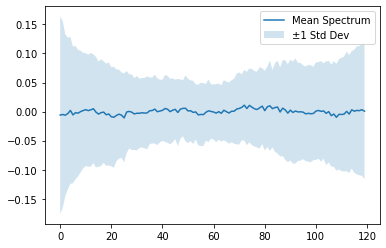

In [8]:
arr_mean = spec_arrays.mean(axis=0)
arr_std  = spec_arrays.std(axis=0)

x_vals = np.arange(len(arr_mean))
plt.plot(x_vals, arr_mean, label="Mean Spectrum")
plt.fill_between(
    x_vals,
    arr_mean - arr_std,
    arr_mean + arr_std,
    alpha=0.2,
    label="±1 Std Dev"
)
plt.legend()
plt.show()


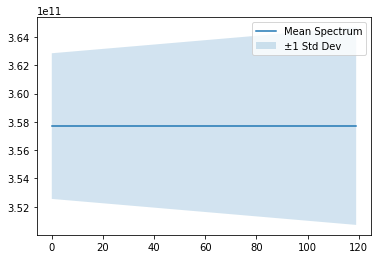

In [9]:
arr_mean = freq_array.mean(axis=0)
arr_std  = freq_array.std(axis=0)

x_vals = np.arange(len(arr_mean))
plt.plot(x_vals, arr_mean, label="Mean Spectrum")
plt.fill_between(
    x_vals,
    arr_mean - arr_std,
    arr_mean + arr_std,
    alpha=0.2,
    label="±1 Std Dev"
)
plt.legend()
plt.show()


# Performing Scan Statistics with Trivial Score Function

In [ ]:
def score(array, a, b):
    region_in = array[a : b + 1]
    region_out = array[:a] + array[b + 1:]
    
    if len(region_in) < 2 or len(region_out) < 2:
        return -np.inf
    
    gamma_1 = np.mean(region_in)
    gamma_2 = np.mean(region_out)
    tau_1 = np.var(region_in, ddof=1)
    tau_2 = np.var(region_out, ddof=1)
    return (gamma_1 - gamma_2) / np.sqrt((tau_1 ** 2 + tau_2 ** 2) / 2)

In [ ]:
range_list = []
score_list = []
for x in spec_arrays:
    max_score = -np.inf
    max_i_j = (-1, -1)
    for i in range(len(x) - 1):
        for j in range(i + 1, len(x)):
            curr_score = score(x, i, j)
            if curr_score > max_score:
                max_score = curr_score
                max_i_j = (i, j)
    range_list.append(max_i_j)
    score_list.append(max_score)

In [ ]:
np.mean([b - a for (a, b) in range_list])

In [ ]:
np.std([b - a for (a, b) in range_list])

In [ ]:
fig, ax = plt.subplots(figsize=(10,200))

for idx, (start, end) in enumerate(range_list):
    ax.hlines(
        y=idx,
        xmin=start,
        xmax=end,
        color="red",
        linewidth=4,
        alpha=0.6
    )
    label_txt = f"[{idx}, {start}, {end}]"
    ax.text(end+0.5, idx, label_txt, va="center")

ax.set_xlim(0, 120)
ax.set_ylim(-1, len(range_list))
ax.set_xlabel("X index")
ax.set_ylabel("Range index")
ax.set_title("Each (index, start,end) in a different horizontal line")
plt.show()

# Performing Gaussian Scan Statistics

In [ ]:
def score_gaussian_scan_stat(array, a, b):
    region_in = array[a : b + 1]
    region_out = array[:a] + array[b + 1:]
    
    if len(region_in) < 2 or len(region_out) < 2:
        return -np.inf
    
    b_r = len(region_in) / len(array)
    m_r = np.sum(region_in) / np.sum(array)
    return (m_r - b_r) ** 2 / (b_r * (1 - b_r))

In [ ]:
range_cap = 30

In [ ]:
range_list = []
score_list = []
for x in spec_arrays:
    max_score = -np.inf
    max_i_j = (-1, -1)
    # mu = np.mean(x)
    # sigma = [(x[i] - mu) ** 2 for i in range(len(x))]
    # x_arr = np.array(x, dtype=float)
    # sigma_arr = np.array(sigma, dtype=float)
    # G = np.sum(x_arr / sigma_arr) / np.sum(1 / sigma_arr)
    for i in range(len(x) - 1):
        for j in range(i + 1, min(i + range_cap + 1, len(x))):
            curr_score = score_gaussian_scan_stat(x, i, j)
            if curr_score > max_score:
                max_score = curr_score
                max_i_j = (i, j)
    range_list.append(max_i_j)
    score_list.append(max_score)

In [ ]:
k = 5

score_list_np = np.array(score_list)
finite_mask = np.isfinite(score_list_np)
finite_indices = np.where(finite_mask)[0]
finite_values = score_list_np[finite_mask]
sorted_indices_among_finite = np.argsort(finite_values)
top_k_among_finite = sorted_indices_among_finite[-k:][::-1]
top_k_original_indices = finite_indices[top_k_among_finite]

top_k_original_indices

In [ ]:
fig, ax = plt.subplots(figsize=(50, 10))

top_k_spec_arrays = spec_arrays[top_k_original_indices]
top_k_range_list = np.array(range_list)[top_k_original_indices]
cmap = plt.cm.rainbow
num_rows = top_k_spec_arrays.shape[0]
colors = cmap(np.linspace(0, 1, num_rows))

for i, row in enumerate(top_k_spec_arrays):
    x = np.arange(len(row))
    
    plt.plot(x, row, color=colors[i], label=f"Row {top_k_original_indices[i]}")
    plt.fill_between(
        x[top_k_range_list[i][0]:top_k_range_list[i][1]+1],
        0,
        row[top_k_range_list[i][0]:top_k_range_list[i][1]+1],
        color=colors[i],
        alpha=0.2
    )

plt.title("Top k scored rows with highlighted ranges (fill_between)")
plt.xlabel("Index (0 to 119)")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
k = 5

score_list_np = np.array(score_list)
finite_mask = np.isfinite(score_list_np)
finite_indices = np.where(finite_mask)[0]
finite_values = score_list_np[finite_mask]
sorted_indices_among_finite = np.argsort(finite_values)
bottom_k_among_finite = sorted_indices_among_finite[:k][::-1]
bottom_k_original_indices = finite_indices[bottom_k_among_finite]

bottom_k_original_indices

In [ ]:
fig, ax = plt.subplots(figsize=(50, 10))

bottom_k_spec_arrays = spec_arrays[bottom_k_original_indices]
bottom_k_range_list = np.array(range_list)[bottom_k_original_indices]
cmap = plt.cm.rainbow
num_rows = bottom_k_spec_arrays.shape[0]
colors = cmap(np.linspace(0, 1, num_rows))

for i, row in enumerate(bottom_k_spec_arrays):
    x = np.arange(len(row))
    
    plt.plot(x, row, color=colors[i], label=f"Row {bottom_k_original_indices[i]}")
    plt.fill_between(
        x[bottom_k_range_list[i][0]:bottom_k_range_list[i][1]+1],
        0,
        row[bottom_k_range_list[i][0]:bottom_k_range_list[i][1]+1],
        color=colors[i],
        alpha=0.2
    )

plt.title("Bottom k scored rows with highlighted ranges (fill_between)")
plt.xlabel("Index (0 to 119)")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
np.max([b - a for (a, b) in range_list])

In [ ]:
np.min([b - a for (a, b) in range_list])

In [ ]:
np.mean([b - a for (a, b) in range_list])

In [ ]:
np.std([b - a for (a, b) in range_list])

In [ ]:
fig, ax = plt.subplots(figsize=(10,200))

for idx, (start, end) in enumerate(range_list):
    ax.hlines(
        y=idx,
        xmin=start,
        xmax=end,
        color="red",
        linewidth=4,
        alpha=0.6
    )
    label_txt = f"[{idx}, {start}, {end}]"
    ax.text(end+0.5, idx, label_txt, va="center")

ax.set_xlim(0, 120)
ax.set_ylim(-1, len(range_list))
ax.set_xlabel("X index")
ax.set_ylabel("Range index")
ax.set_title("Each (index, start,end) in a different horizontal line")
plt.show()

# Performing Polynomial Fitting with Gaussian Scan Statistics

In [10]:
spec_arrays_simulated_linear = np.array([[10.88, 10.2, 60.08, 59.45, 60.35, 9.51, 10.48, 9.92, 9.95, 10.21, 10.07, 10.73, 10.38, 10.06, 10.22, 10.17, 10.75, 9.9, 10.16, 9.57],
 [10.1, 10.2, 10.23, 9.99, 10.19, 60.45, 59.9, 60.11, 60.31, 60.07, 10.44, 10.03, 10.29, 10.32, 9.95, 10.22, 10.34, 10.23, 10.01, 9.85],
 [10.0, 10.11, 10.25, 9.86, 10.22, 9.84, 10.18, 10.27, 60.3, 60.1, 60.57, 60.31, 10.1, 9.97, 10.0, 10.15, 9.86, 10.21, 10.38, 10.2],
 [10.01, 10.01, 9.91, 10.21, 10.08, 9.96, 10.25, 10.15, 10.11, 10.07, 10.22, 60.22, 60.05, 60.11, 60.56, 60.3, 10.02, 9.94, 10.03, 10.18],
 [9.98, 10.0, 10.08, 10.14, 9.98, 10.15, 9.96, 10.19, 10.24, 10.17, 10.11, 10.04, 10.21, 10.23, 10.01, 10.08, 60.7, 60.25, 60.39, 60.51]])

In [11]:
np.random.seed(42)
x = np.linspace(0, 10, 120)
num_outliers = 5
range_cap = 10
spec_arrays_simulated_list = []
outlier_indices_list = []

for _ in range(5):
    a = np.random.uniform(0.05, 0.15)
    b = np.random.uniform(-0.7, -0.3)
    c = np.random.uniform(1.3, 1.7)
    d = np.random.uniform(9, 11)
    
    y = a * x**3 + b * x**2 + c * x + d
    
    y += np.random.normal(0, 10, size=x.shape)
    
    start_index = np.random.randint(range_cap, len(x) - num_outliers - range_cap + 1)
    outlier_indices = np.arange(start_index, start_index + num_outliers)
    outlier_indices_list.append(outlier_indices)
    offset_multiplier = np.random.choice([1, 2, 3, 4, 5])
    offset = offset_multiplier * np.random.choice([-30, 30])
    y[outlier_indices] += offset
    spec_arrays_simulated_list.append(y)

spec_arrays_simulated_polynomial = np.array(spec_arrays_simulated_list)

df_simulated = pd.DataFrame(spec_arrays_simulated_list)
df_simulated.head()


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,7.855783,7.987590,26.248527,18.254292,6.005165,16.242204,6.296163,6.384132,13.569806,-7.875891,...,64.753124,71.228126,69.431502,59.688165,84.430169,82.179249,84.259510,68.976191,93.850801,67.589366
1,10.369551,4.455758,-5.903599,10.396438,-0.808993,14.648878,0.813505,25.597978,2.353291,7.048913,...,31.318418,47.292780,31.693565,39.340105,46.424622,50.938373,31.202931,40.805170,40.364439,39.563942
2,26.868839,5.808525,11.421224,4.739267,3.975830,8.245358,8.172683,5.036073,5.677198,22.229391,...,94.062857,77.514600,105.282175,98.919409,123.652533,109.956731,116.084565,122.381545,118.730487,123.334820
3,24.557632,19.777385,31.848428,2.768707,19.284823,12.508531,32.680898,2.802113,2.584776,5.079844,...,14.020740,32.762256,23.822449,17.837881,26.285479,22.643050,51.054006,43.739988,35.602011,51.256675
4,23.524871,-3.419059,-9.357464,19.289475,10.243738,11.325009,6.516421,7.820224,5.694223,4.081656,...,66.458262,54.117321,81.209422,107.921643,81.581938,86.247133,105.810741,96.146968,94.712383,99.309369


In [12]:
outlier_indices_list

[array([79, 80, 81, 82, 83]),
 array([57, 58, 59, 60, 61]),
 array([94, 95, 96, 97, 98]),
 array([95, 96, 97, 98, 99]),
 array([101, 102, 103, 104, 105])]

In [13]:
spec_arrays_actual = spec_arrays.copy()

In [14]:
spec_arrays_cut = spec_arrays_actual[:]

In [15]:
def score_gaussian_scan_stat(array, a, b):
    region_in = array[a : b + 1]
    region_out = np.concatenate((array[:a], array[b + 1:]))
    
    if len(region_in) < 2 or len(region_out) < 2:
        return -np.inf
    
    b_r = len(region_in) / len(array)
    m_r = np.sum(region_in) / np.sum(array)
    return (m_r - b_r) / (b_r * (1 - b_r))

In [16]:
def score_variance_scan_stat(array, a, b):
    region_in = array[a : b + 1]
    region_out = np.concatenate((array[:a], array[b + 1:]))
    
    if len(region_in) < 2 or len(region_out) < 2:
        return -np.inf

    ave_in = np.sum(region_in) / len(region_in)
    ave_out = np.sum(region_out) / len(region_out)

    return -(np.sum((region_in - ave_in)**2) + np.sum((region_out - ave_out)**2))

In [17]:
def score_huang_gaussian_scan_stat(array, a, b):
    region_in = array[a : b + 1]
    region_out = np.concatenate((array[:a], array[b + 1:]))
    
    if len(region_in) < 2 or len(region_out) < 2:
        return -np.inf

    return ((np.sum(region_in)**2) / len(region_in) + (np.sum(region_out)**2) / len(region_out)) / len(array)

In [18]:
def score_nadaray_wattson_scan_stat(array, a, b, w=5):
    indices = np.arange(len(array))
    indices = np.concatenate([indices[:a], indices[b + 1:]])
    residuals = []
    
    for idx in range(a, b + 1):
        weights = np.exp(-((idx - indices) ** 2) / (w ** 2))
        pred = np.sum(weights * array[indices]) / np.sum(weights)
        residuals.append(array[idx] - pred)
    
    residuals = np.array(residuals)
    score = np.sum(residuals ** 2) / (b - a)
    return score


In [19]:
def calucalte_nwkr_sra(array, w=5):
    indices = np.arange(len(array))
    residuals = []
    for idx in range(len(array)):
        weights = np.exp(-((idx - indices) ** 2) / (w ** 2))
        pred = np.sum(weights * array[indices]) / np.sum(weights)
        residuals.append(array[idx] - pred)
    return np.sum(np.array(residuals) ** 2)

In [20]:
def score_variance_nadaray_wattson_scan_stat(array, a, b, w=5):
    indices = np.arange(len(array))
    indices_in = indices[a:b+1]
    indices_out = np.concatenate([indices[:a], indices[b+1:]])
    
    if indices_in.size > 0:
        diff_in = np.abs(np.subtract.outer(indices_in, indices_in))
        weights_in = np.exp(- (diff_in ** 2) / (w ** 2))
        sum_w_in = weights_in.sum(axis=1)
        pred_in = np.einsum('ij,j->i', weights_in, array[indices_in]) / sum_w_in
        residuals_in = array[indices_in] - pred_in
        sri = np.sum(residuals_in ** 2)
    else:
        sri = 0

    if indices_out.size > 0:
        diff_out = np.abs(np.subtract.outer(indices_out, indices_out))
        weights_out = np.exp(- (diff_out ** 2) / (w ** 2))
        sum_w_out = weights_out.sum(axis=1)
        pred_out = np.einsum('ij,j->i', weights_out, array[indices_out]) / sum_w_out
        residuals_out = array[indices_out] - pred_out
        sro = np.sum(residuals_out ** 2)
    else:
        sro = 0

    return -(sro + sri)

In [21]:
def calucalte_laplacekr_sra(array, w=5):
    indices = np.arange(len(array))
    residuals = []
    for idx in range(len(array)):
        weights = np.exp(-np.abs(idx - indices) / w)
        pred = np.sum(weights * array) / np.sum(weights)
        residuals.append(array[idx] - pred)
    return np.sum(np.square(residuals))

In [22]:
def score_variance_laplacekr_scan_stat(array, a, b, w=5):
    indices = np.arange(len(array))
    indices_in  = indices[a:b+1]
    indices_out = np.concatenate([indices[:a], indices[b+1:]])
    
    if indices_in.size > 0:
        diff_in      = np.abs(np.subtract.outer(indices_in, indices_in))
        weights_in   = np.exp(- diff_in / w)
        sum_w_in     = weights_in.sum(axis=1)
        pred_in      = np.einsum('ij,j->i', weights_in, array[indices_in]) / sum_w_in
        residuals_in = array[indices_in] - pred_in
        sri          = np.sum(np.square(residuals_in))
    else:
        sri = 0

    if indices_out.size > 0:
        diff_out      = np.abs(np.subtract.outer(indices_out, indices_out))
        weights_out   = np.exp(- diff_out / w)
        sum_w_out     = weights_out.sum(axis=1)
        pred_out      = np.einsum('ij,j->i', weights_out, array[indices_out]) / sum_w_out
        residuals_out = array[indices_out] - pred_out
        sro           = np.sum(np.square(residuals_out))
    else:
        sro = 0

    return -(sro + sri)

In [23]:
def polynomial_subtracted_array(x, i, j, poly_degree=3, indices=None):
    if poly_degree == 0:
        return x, None

    n = len(x)
    if indices is None:
        indices = np.arange(n)

    p_indices = np.r_[indices[:i], indices[j+1:]]
    if p_indices.size <= poly_degree:
        return x, None
    
    y_p = np.concatenate((x[:i], x[j+1:]))
    
    coeffs = np.polyfit(p_indices, y_p, poly_degree)
    poly_func = np.poly1d(coeffs)
    x_sub = x - poly_func(indices)
    
    return x_sub, poly_func

In [24]:
def polynomial_scan_ranges(spec_arrays, function, range_cap=20, poly_degree=3, buffer=10, w=5):
    range_list = []
    score_list = []
    poly_list = []
    x_sub_list = []
    temp_range = []
    temp_score = []
    flag = False

    t_start = time.perf_counter()
    for idx, x in enumerate(tqdm(spec_arrays, desc="Rows")):
        row_start = time.perf_counter()
        n = len(x)
        indices = np.arange(n)
        max_score = -np.inf
        max_i_j = (-1, -1)
        max_poly = None
        max_x_sub = None

        if function == score_variance_nadaray_wattson_scan_stat:
            sra = calucalte_nwkr_sra(x)
        
        start = buffer
        end = n - buffer - 1
        for i in range(start, end):
            max_j = min(i + range_cap + 1, n - buffer)
            for j in range(i + 1, max_j):
                if function in (score_nadaray_wattson_scan_stat, score_variance_nadaray_wattson_scan_stat, score_variance_laplacekr_scan_stat):
                    x_sub, poly_func = x, None
                    curr_score = function(x_sub, i, j, w)
                else:
                    x_sub, poly_func = polynomial_subtracted_array(
                        x, i, j, poly_degree=poly_degree, indices=indices)
                    curr_score = function(x_sub, i, j)
                
                if function == score_variance_nadaray_wattson_scan_stat:
                    curr_score = curr_score / sra + 1

                if not flag:
                    temp_range.append((i, j))
                    temp_score.append(curr_score)
                
                if curr_score > max_score:
                    max_score = curr_score
                    max_i_j = (i, j)
                    max_poly = poly_func
                    max_x_sub = x_sub
        
        range_list.append(max_i_j)
        score_list.append(max_score)
        poly_list.append(max_poly)
        x_sub_list.append(max_x_sub)
        flag = True

        row_end = time.perf_counter()

    t_end = time.perf_counter()
    print(f"Total scan time: {t_end - t_start:.3f}s")

    return range_list, score_list, poly_list, x_sub_list, temp_range, temp_score


In [25]:
def lorentzian(x, p0, w):
    c = 1/np.sqrt(1 - 2/np.pi)
    return 1/(np.pi * (1 + ((x - p0)/(c*w))**2))

In [26]:
def subtract_interference(row, p0, w, gamma):
    x = np.arange(len(row))
    return row - gamma * lorentzian(x, p0, w)

In [27]:
def optimize_gamma_for_row(row, p0, w, a, b, gamma_range):
    best_gamma = None
    best_score = -np.inf
    for gamma in gamma_range:
        row_adjusted = subtract_interference(row, p0, w, gamma)
        score = score_variance_nadaray_wattson_scan_stat(row_adjusted, a, b, w)
        if score > best_score:
            best_score = score
            best_gamma = gamma
    return best_gamma, best_score

In [28]:
def subtract_interference_from_spec_arrays(spec_arrays, p0, w, a, b, gamma_range):
    updated_rows = []
    gamma_values = []
    for row in spec_arrays:
        best_gamma, _ = optimize_gamma_for_row(row, p0, w, a, b, gamma_range)
        gamma_values.append(best_gamma)
        updated_rows.append(subtract_interference(row, p0, w, best_gamma))
    return np.array(updated_rows), gamma_values

In [32]:
spec_arrays = spec_arrays_actual
function = score_variance_nadaray_wattson_scan_stat

In [33]:
def run_scan_with_interference_removal(spec_arrays, p0, w, function):
    gamma_range = np.linspace(0, 10, 21)
    
    spec_arrays_clean, gamma_vals = subtract_interference_from_spec_arrays(spec_arrays, p0, w, a, b, gamma_range)
    print("Optimized gamma values per row:")
    print(gamma_vals)
    
    range_list, score_list, poly_list, x_sub_list, temp_range, temp_score = polynomial_scan_ranges(
        spec_arrays_clean, function, range_cap=120, poly_degree=3, buffer=0)
    return range_list, score_list, poly_list, x_sub_list, temp_range, temp_score

In [48]:
range_list, score_list, poly_list, x_sub_list, temp_range, temp_score = polynomial_scan_ranges(spec_arrays, function, range_cap=20, poly_degree=3, buffer=10, w=10)

Rows: 100%|██████████| 680/680 [02:52<00:00,  3.94it/s]

Total scan time: 172.668s


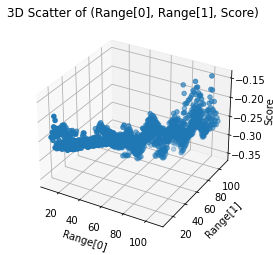

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

temp_range_np = np.array(temp_range)
ax.scatter(temp_range_np[:, 0], temp_range_np[:, 1], temp_score)

ax.set_xlabel("Range[0]")
ax.set_ylabel("Range[1]")
ax.set_zlabel("Score")

plt.title("3D Scatter of (Range[0], Range[1], Score)")
plt.show()

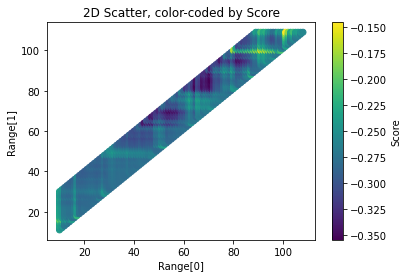

In [50]:
plt.scatter(temp_range_np[:, 0], temp_range_np[:, 1], c=temp_score, cmap='viridis')
plt.colorbar(label='Score')
plt.xlabel("Range[0]")
plt.ylabel("Range[1]")
plt.title("2D Scatter, color-coded by Score")
plt.show()

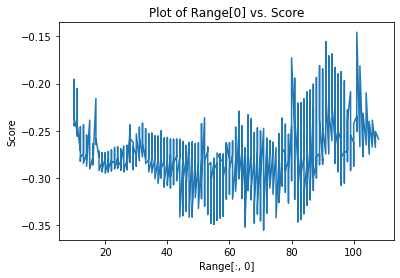

In [51]:
plt.plot(temp_range_np[:, 0], temp_score)
plt.xlabel("Range[:, 0]")
plt.ylabel("Score")
plt.title("Plot of Range[0] vs. Score")
plt.show()

In [52]:
k = 10

score_list_np = np.array(score_list)
finite_mask = np.isfinite(score_list_np)
finite_indices = np.where(finite_mask)[0]
finite_values = score_list_np[finite_mask]
sorted_indices_among_finite = np.argsort(finite_values)
top_k_among_finite = sorted_indices_among_finite[-k:][::-1]
top_k_original_indices = finite_indices[top_k_among_finite]

top_k_original_indices

array([ 10,  55,  39, 391, 565, 378, 348, 548, 363, 511])

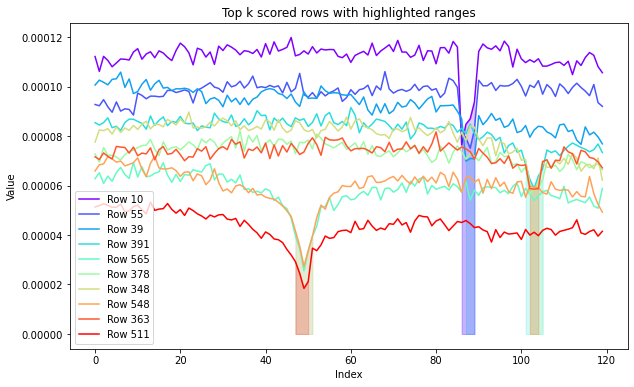

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))

top_k_score_list = [score_list[idx] for idx in top_k_original_indices]
top_k_spec_arrays = spec_arrays[top_k_original_indices]
top_k_range_list = np.array(range_list)[top_k_original_indices]
top_k_poly_list = [poly_list[idx] for idx in top_k_original_indices]
top_k_x_sub_list = [x_sub_list[idx] for idx in top_k_original_indices]

cmap = plt.cm.rainbow
num_rows = top_k_spec_arrays.shape[0]
colors = cmap(np.linspace(0, 1, num_rows))

for i, row in enumerate(top_k_spec_arrays):
    x = np.arange(len(row))
    start, end = top_k_range_list[i]
    best_poly_func = top_k_poly_list[i]
    plt.plot(x, row, color=colors[i], label=f"Row {top_k_original_indices[i]}")
    plt.fill_between(
        x[start : end + 1],
        0,
        row[start : end + 1],
        color=colors[i],
        alpha=0.2
    )
    
    if best_poly_func is not None:
        poly_vals = best_poly_func(x)
        plt.plot(x, poly_vals, color=colors[i], linestyle='--', linewidth=3,
                 label=f"Poly Fit (Row {top_k_original_indices[i]})")

plt.title("Top k scored rows with highlighted ranges")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

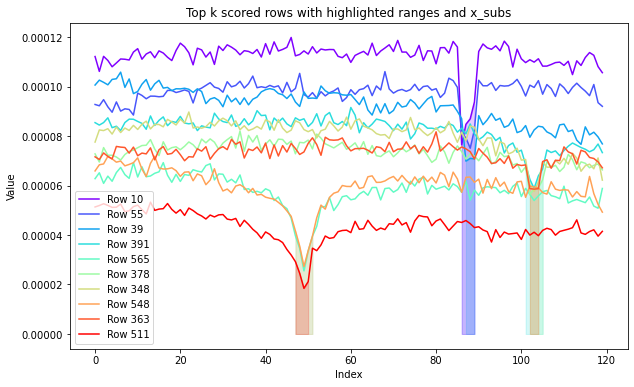

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, row in enumerate(top_k_x_sub_list):
    x = np.arange(len(row))
    start, end = top_k_range_list[i]
    plt.plot(x, row, color=colors[i], label=f"Row {top_k_original_indices[i]}")
    plt.fill_between(
        x[start : end + 1],
        0,
        row[start : end + 1],
        color=colors[i],
        alpha=0.2
    )

plt.title("Top k scored rows with highlighted ranges and x_subs")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

In [55]:
top_k_ref_antenna_name_array = ref_antenna_name_array[top_k_original_indices]
top_k_antenna_array = antenna_array[top_k_original_indices]
top_k_polarization_array = polarization_array[top_k_original_indices]
top_k_freq_array = freq_array[top_k_original_indices]

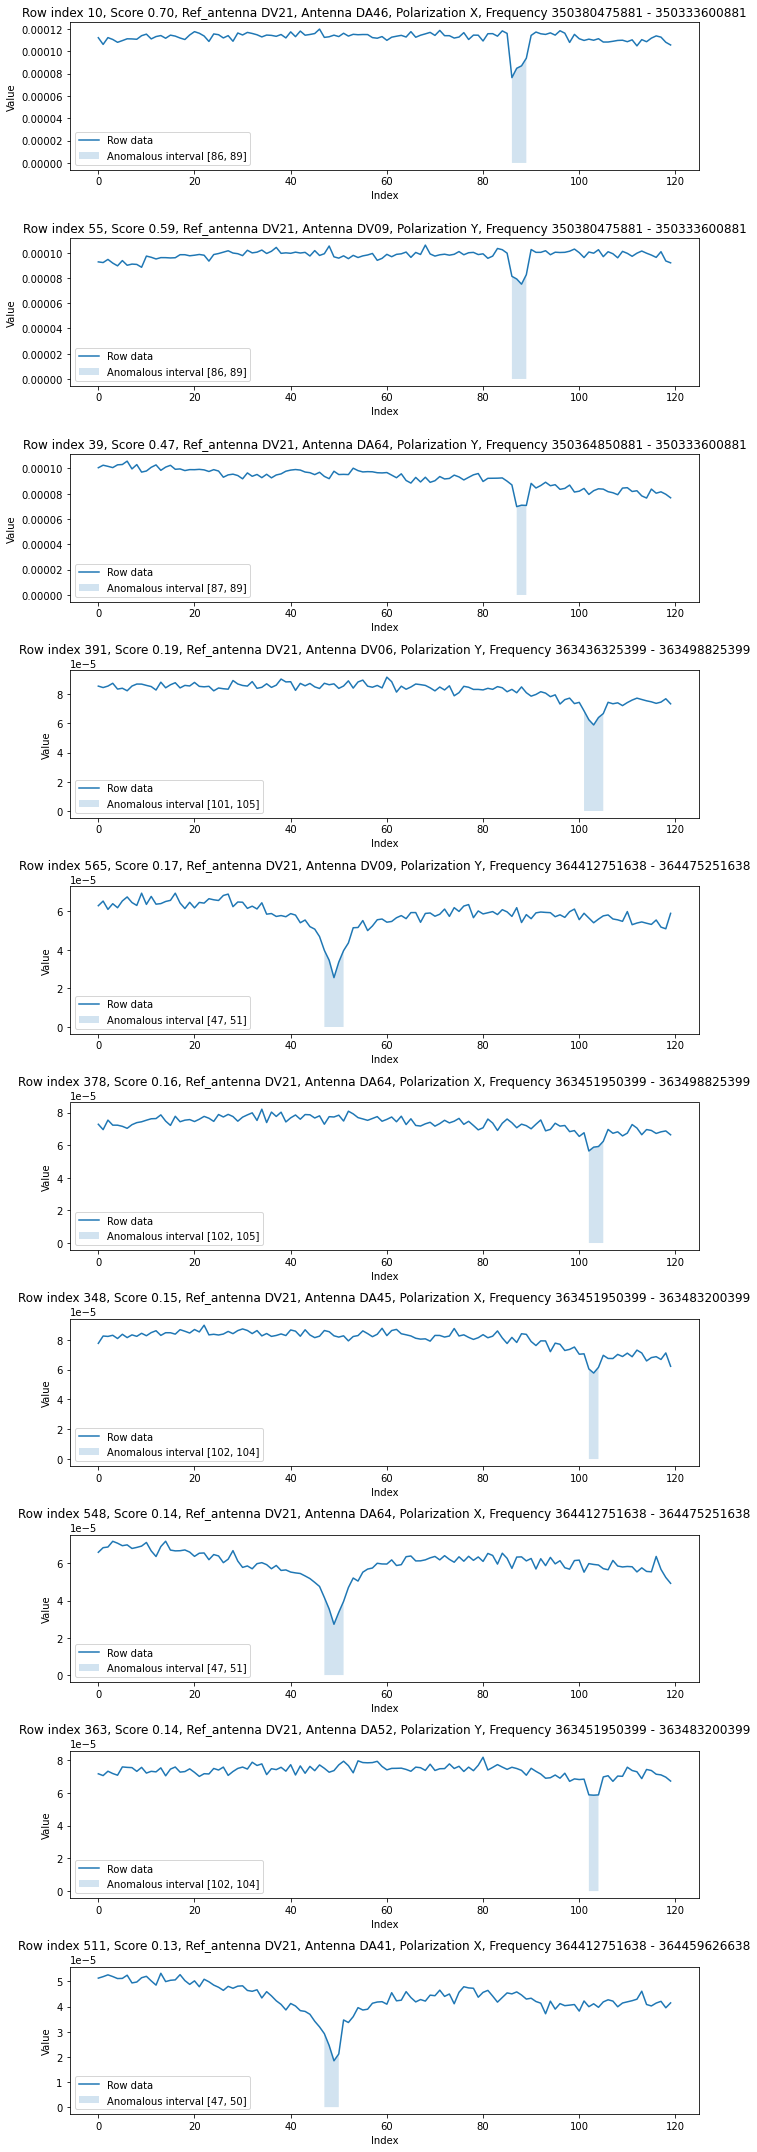

In [56]:
fig, axes = plt.subplots(nrows=k, ncols=1, figsize=(10, 3 * k))

if k == 1:
    axes = [axes]

for i in range(k):
    ax = axes[i]
    row = top_k_spec_arrays[i]
    (start, end) = top_k_range_list[i]
    best_poly_func = top_k_poly_list[i]
    
    x = np.arange(len(row))
    
    ax.plot(x, row, label="Row data")
    
    ax.fill_between(
        x[start : end + 1],
        0,
        row[start : end + 1],
        alpha=0.2,
        label=f"Anomalous interval [{start}, {end}]"
    )
    
    if best_poly_func is not None:
        ax.plot(x, best_poly_func(x), linestyle='--',
                label="Fitted polynomial")

    if top_k_original_indices is not None:
        ax.set_title(f"Row index {top_k_original_indices[i]}, Score {top_k_score_list[i]:.2f}, Ref_antenna {top_k_ref_antenna_name_array[i]}, Antenna {top_k_antenna_array[i]}, Polarization {top_k_polarization_array[i]}, Frequency {top_k_freq_array[i][start]:.0f} - {top_k_freq_array[i][end]:.0f}")
    else:
        ax.set_title(f"Top-k Row {i}")

    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()

In [57]:
k = 10

score_list_np = np.array(score_list)
finite_mask = np.isfinite(score_list_np)
finite_indices = np.where(finite_mask)[0]
finite_values = score_list_np[finite_mask]
sorted_indices_among_finite = np.argsort(finite_values)
bottom_k_among_finite = sorted_indices_among_finite[:k][::-1]
bottom_k_original_indices = finite_indices[bottom_k_among_finite]

bottom_k_original_indices

array([319, 271, 295, 263,  86, 296, 143, 661, 299,  93])

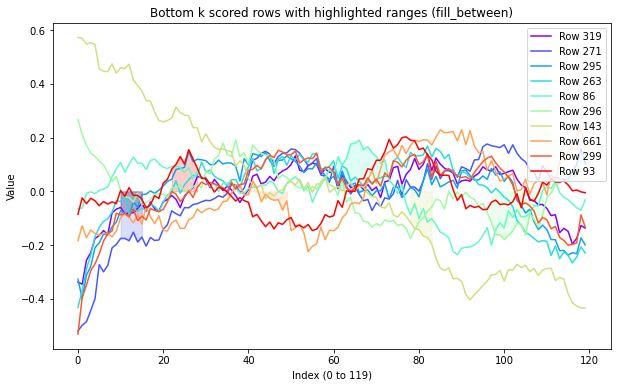

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

bottom_k_score_list = [score_list[idx] for idx in bottom_k_original_indices]
bottom_k_spec_arrays = spec_arrays[bottom_k_original_indices]
bottom_k_range_list = np.array(range_list)[bottom_k_original_indices]
bottom_k_poly_list = [poly_list[idx] for idx in bottom_k_original_indices]
bottom_k_x_sub_list = [x_sub_list[idx] for idx in bottom_k_original_indices]
cmap = plt.cm.rainbow
num_rows = bottom_k_spec_arrays.shape[0]
colors = cmap(np.linspace(0, 1, num_rows))

for i, row in enumerate(bottom_k_spec_arrays):
    x = np.arange(len(row))
    
    plt.plot(x, row, color=colors[i], label=f"Row {bottom_k_original_indices[i]}")
    plt.fill_between(
        x[bottom_k_range_list[i][0]:bottom_k_range_list[i][1]+1],
        0,
        row[bottom_k_range_list[i][0]:bottom_k_range_list[i][1]+1],
        color=colors[i],
        alpha=0.2
    )

plt.title("Bottom k scored rows with highlighted ranges (fill_between)")
plt.xlabel("Index (0 to 119)")
plt.ylabel("Value")
plt.legend()
plt.show()

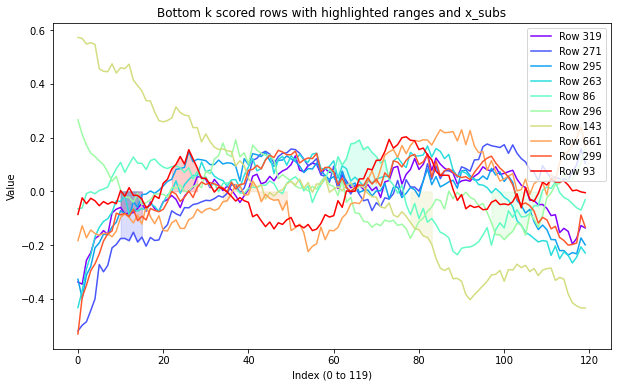

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, row in enumerate(bottom_k_x_sub_list):
    x = np.arange(len(row))
    
    plt.plot(x, row, color=colors[i], label=f"Row {bottom_k_original_indices[i]}")
    plt.fill_between(
        x[bottom_k_range_list[i][0]:bottom_k_range_list[i][1]+1],
        0,
        row[bottom_k_range_list[i][0]:bottom_k_range_list[i][1]+1],
        color=colors[i],
        alpha=0.2
    )

plt.title("Bottom k scored rows with highlighted ranges and x_subs")
plt.xlabel("Index (0 to 119)")
plt.ylabel("Value")
plt.legend()
plt.show()

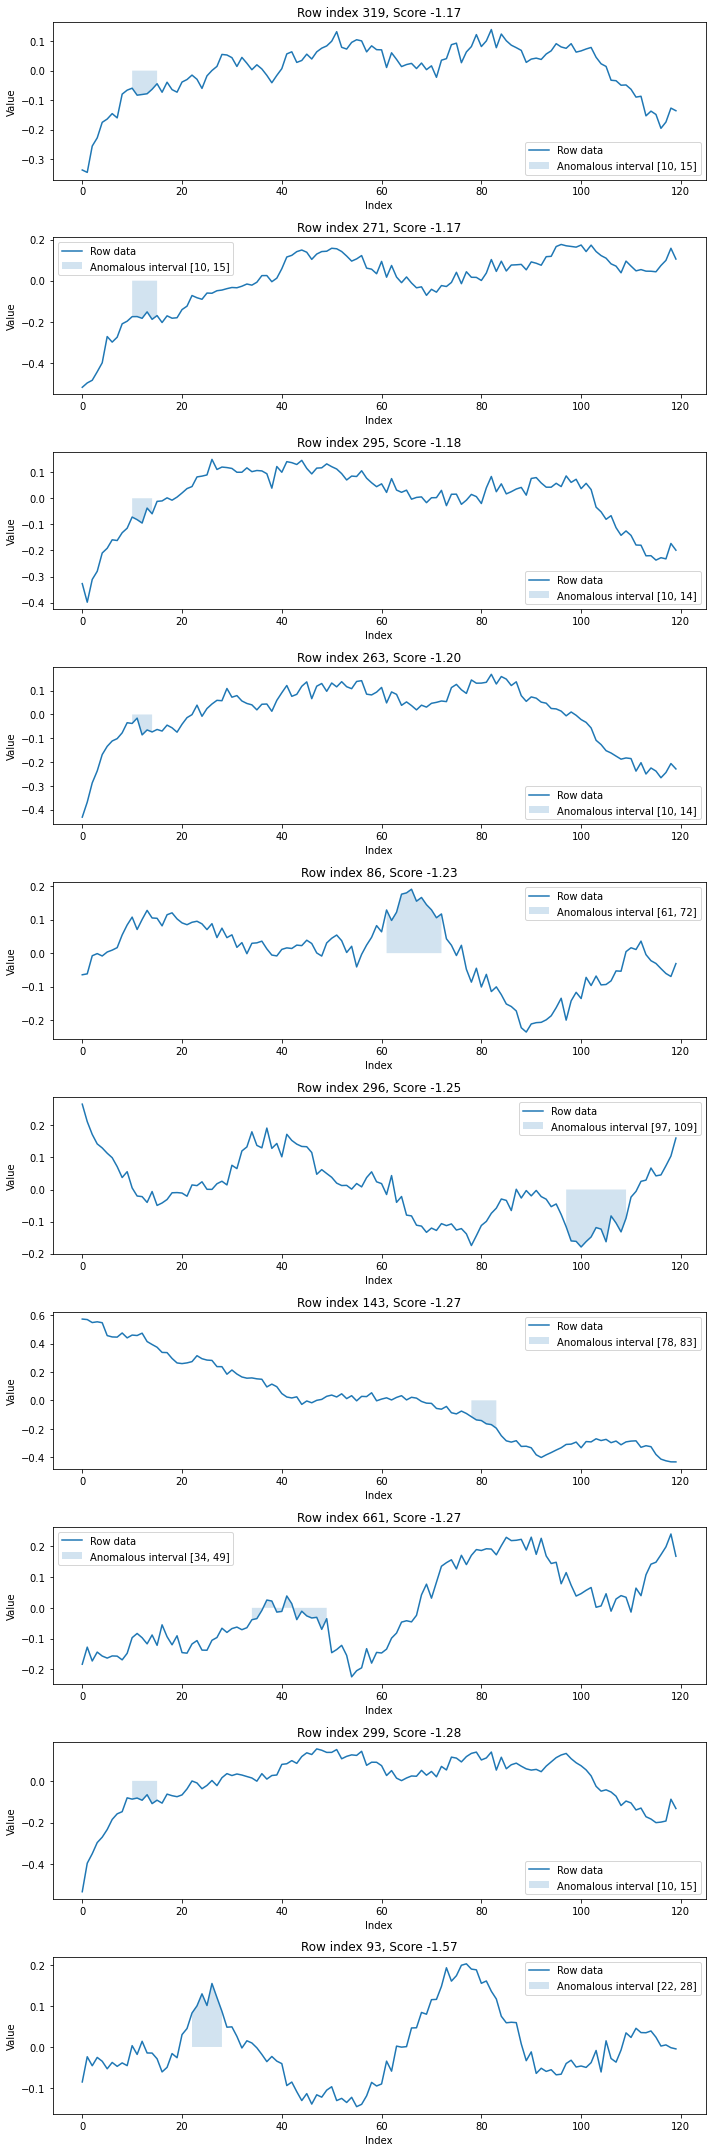

In [60]:
fig, axes = plt.subplots(nrows=k, ncols=1, figsize=(10, 3 * k))

if k == 1:
    axes = [axes]

for i in range(k):
    ax = axes[i]
    row = bottom_k_spec_arrays[i]
    (start, end) = bottom_k_range_list[i]
    best_poly_func = bottom_k_poly_list[i]
    
    x = np.arange(len(row))
    
    ax.plot(x, row, label="Row data")
    
    ax.fill_between(
        x[start : end + 1],
        0,
        row[start : end + 1],
        alpha=0.2,
        label=f"Anomalous interval [{start}, {end}]"
    )
    
    if best_poly_func is not None:
        ax.plot(x, best_poly_func(x), linestyle='--',
                label="Fitted polynomial")

    if bottom_k_original_indices is not None:
        ax.set_title(f"Row index {bottom_k_original_indices[i]}, Score {bottom_k_score_list[i]:.2f}")
    else:
        ax.set_title(f"Bottom-k Row {i}")

    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()

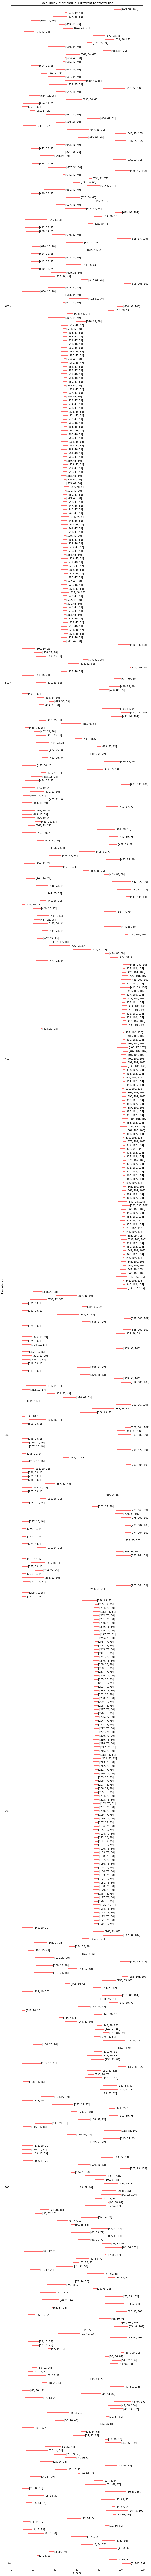

In [61]:
fig, ax = plt.subplots(figsize=(10,200))

for idx, (start, end) in enumerate(range_list):
    ax.hlines(
        y=idx,
        xmin=start,
        xmax=end,
        color="red",
        linewidth=4,
        alpha=0.6
    )
    label_txt = f"[{idx}, {start}, {end}]"
    ax.text(end+0.5, idx, label_txt, va="center")

ax.set_xlim(0, 120)
ax.set_ylim(-1, len(range_list))
ax.set_xlabel("X index")
ax.set_ylabel("Range index")
ax.set_title("Each (index, start,end) in a different horizontal line")
plt.show()